In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import os
from lime import lime_image
from skimage.segmentation import mark_boundaries
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # Панацея от отвала ядра 

In [24]:
#!/bin/bash
!curl -L -o alpaca-dataset-small.zip  https://www.kaggle.com/api/v1/datasets/download/sid4sal/alpaca-dataset-small

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  116M    0 81848    0     0  97248      0  0:20:53 --:--:--  0:20:53 97248
 13  116M   13 15.2M    0     0  8836k      0  0:00:13  0:00:01  0:00:12 16.4M
 43  116M   43 50.4M    0     0  18.1M      0  0:00:06  0:00:02  0:00:04 25.9M
 74  116M   74 86.2M    0     0  22.8M      0  0:00:05  0:00:03  0:00:02 29.3M
100  116M  100  116M    0     0  25.1M      0  0:00:04  0:00:04 --:--:-- 30.6M


In [25]:
import zipfile

with zipfile.ZipFile("alpaca-dataset-small.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
print("Распаковка завершена.")

Распаковка завершена.


In [26]:
import os
import shutil
import random

# Исходная папка с подкатегориями
source_dir = 'dataset/dataset'
target_root = 'dataset_split'  # Новая папка для train/val/test

splits = ['train', 'val', 'test']
split_ratios = {'train': 0.8, 'val': 0.1, 'test': 0.1}

# Получаем классы (папки)
classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

for cls in classes:
    cls_dir = os.path.join(source_dir, cls)
    images = os.listdir(cls_dir)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * split_ratios['train'])
    n_val = int(n_total * split_ratios['val'])
    
    split_data = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }

    for split in splits:
        split_dir = os.path.join(target_root, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img_name in split_data[split]:
            src = os.path.join(cls_dir, img_name)
            dst = os.path.join(split_dir, img_name)
            shutil.copy2(src, dst)

print("Разделение завершено: train / val / test.")


Разделение завершено: train / val / test.


In [27]:
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

# Трансформации
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Путь к новому датасету
data_dir = './dataset_split'

# Загружаем imagefolder по каждому сплиту
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

# DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                   shuffle=True if x != 'test' else False,
                                   num_workers=4)
    for x in ['train', 'val', 'test']
}

# Размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Названия классов
class_names = image_datasets['train'].classes

# Устройство
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [28]:
dataset_sizes

{'train': 327, 'val': 228, 'test': 248}

In [29]:
class_names

['alpaca', 'not alpaca']

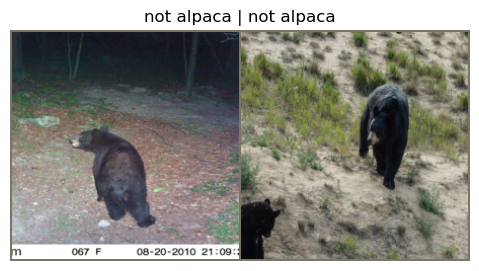

In [43]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Путь к данным
data_dir = './dataset_split'

# Загрузка датасета
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}


class_names = image_datasets['train'].classes

# Визуализация
def imshow(inp_tensor, title=None):
    try:
        inp = inp_tensor.detach().cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        plt.figure(figsize=(6, 3))
        plt.imshow(inp)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.pause(0.001)
        plt.show()
    except Exception as e:
        print("Ошибка в imshow:", e)

# Получение батча и отображение 2 изображений
try:
    inputs, class_ids = next(iter(dataloaders['train']))
    inputs = inputs[:2]
    class_ids = class_ids[:2]
    out = torchvision.utils.make_grid(inputs)

    title = ' | '.join([class_names[x] for x in class_ids])
    imshow(out, title=title)

except StopIteration:
    print("Dataloader пуст — проверь содержимое dataset_split/train/")
except Exception as e:
    print("Ошибка при визуализации батча:", e)


In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [32]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=26)

Epoch 0/25
----------
train Loss: 0.7249 Acc: 0.6330
val Loss: 1.8755 Acc: 0.4342

Epoch 1/25
----------
train Loss: 0.5598 Acc: 0.7431
val Loss: 0.1977 Acc: 0.9298

Epoch 2/25
----------
train Loss: 0.5610 Acc: 0.7462
val Loss: 0.1897 Acc: 0.9474

Epoch 3/25
----------
train Loss: 0.5470 Acc: 0.7798
val Loss: 0.1817 Acc: 0.9123

Epoch 4/25
----------
train Loss: 0.4225 Acc: 0.8043
val Loss: 0.2168 Acc: 0.8991

Epoch 5/25
----------
train Loss: 0.5915 Acc: 0.7645
val Loss: 0.1279 Acc: 0.9561

Epoch 6/25
----------
train Loss: 0.5064 Acc: 0.7798
val Loss: 0.2058 Acc: 0.9123

Epoch 7/25
----------
train Loss: 0.4243 Acc: 0.8257
val Loss: 0.1492 Acc: 0.9430

Epoch 8/25
----------
train Loss: 0.4244 Acc: 0.7768
val Loss: 0.1554 Acc: 0.9386

Epoch 9/25
----------
train Loss: 0.3620 Acc: 0.8502
val Loss: 0.1427 Acc: 0.9386

Epoch 10/25
----------
train Loss: 0.3558 Acc: 0.8471
val Loss: 0.1664 Acc: 0.9342

Epoch 11/25
----------
train Loss: 0.3513 Acc: 0.8379
val Loss: 0.1673 Acc: 0.9342

Ep

In [34]:
def imshow(inp_tensor, title=None):
    """Отображение тензора изображения с денормализацией."""
    inp = inp_tensor.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')


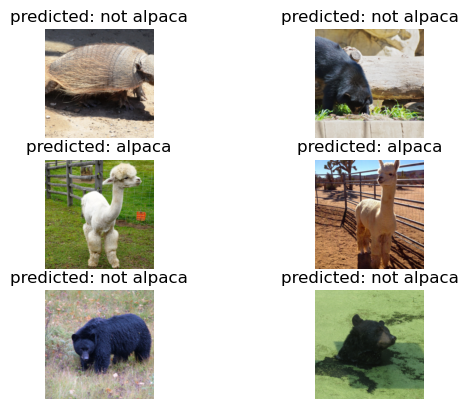

In [35]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model_conv)

plt.ioff()
plt.show()


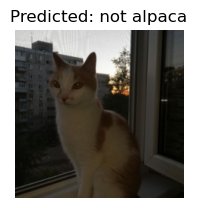

In [36]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

visualize_model_predictions(
    model_conv,
    img_path='./img/first picture.jpg'
)

plt.ioff()
plt.show()



In [37]:
def transform_image_for_model(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms['val'](img)
    return img_tensor.unsqueeze(0).to(device)

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor.cpu() * std + mean

def batch_predict(images):
    model_conv.eval()
    batch = torch.stack([data_transforms['val'](Image.fromarray(img)).to(device) for img in images], dim=0)
    with torch.no_grad():
        logits = model_conv(batch)
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

def explain_prediction_with_lime(img_path):
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    np_img = np.array(img)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np_img,
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )

    plt.figure(figsize=(6, 6))
    plt.title(f"Predicted: {class_names[explanation.top_labels[0]]}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

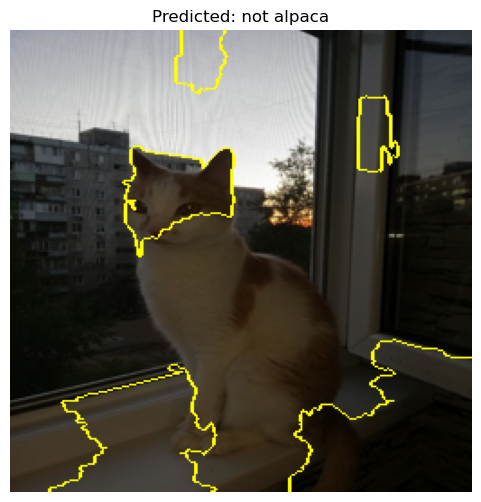

In [38]:
explain_prediction_with_lime("./img/first picture.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

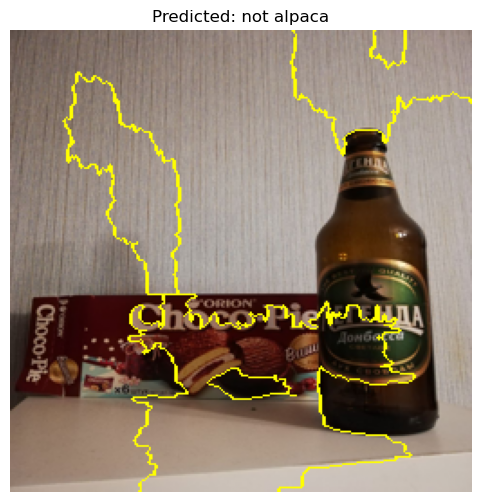

In [39]:
explain_prediction_with_lime("./img/second picture.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

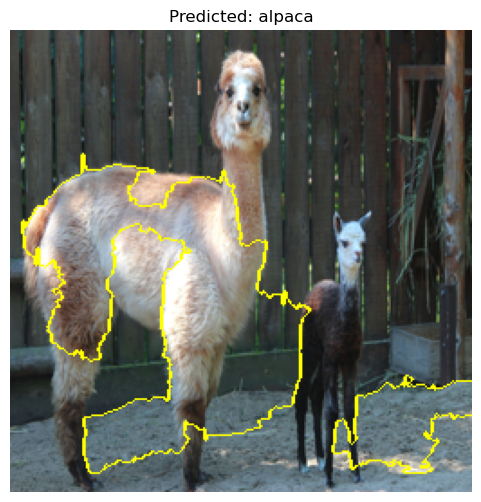

In [40]:
explain_prediction_with_lime("./img/third picture.jpg")